# Numerical Experiments
- We first use a neural net with reLU activation function and with a fully connected layers with 64 units and then another FC layer with 32 unites as our teacher model.

- A smaller student model with 1 layer (32 units) with reLU activation function as our student model.

- We then vary the value of the confidence \alpha to explore the effects it has on the optimizer.

## Imports

In [ ]:
pip install tensorflow --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:
pip install keras --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.1/999.1 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0.post1 requires keras<2.16,>=2.15.0, but you have keras 3.0.1 which is incompatible.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import accuracy_score
import tensorflow as tf
import sklearn as sk
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers


In [ ]:
from keras import ops

# Multi-clas classification wirh Knowledge Distillation on MNIST data

# Set up Distiler class

In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(
        self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
    ):
        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(y, y_pred)

        distillation_loss = self.distillation_loss_fn(
            ops.softmax(teacher_pred / self.temperature, axis=1),
            ops.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)

        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        return loss

    def call(self, x):
        return self.student(x)

## Prepare the data

In [ ]:
# # Prepare the train and test dataset.
# batch_size = 64
# (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# # Normalize data
# x_train = x_train.astype("float32") / 255.0
# x_train = np.reshape(x_train, (-1, 28, 28, 1))

# x_test = x_test.astype("float32") / 255.0
# x_test = np.reshape(x_test, (-1, 28, 28, 1))

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
# Load and preprocess MNIST data
# Prepare the train and test dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))


In [ ]:
x_train

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [ ]:
x_test.shape

(10000, 28, 28, 1)

In [ ]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

## Create student and teacher models

In [ ]:
# Create the teacher
teacher = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(10),
    ],
    name="teacher",
)

# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(10),
    ],
    name="student",
)

# Clone student for later comparison
student_scratch = keras.models.clone_model(student)

## Train the teacher model

In [ ]:

# Train teacher as usual
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate teacher on data.
teacher.fit(x_train, y_train, epochs=10)
teacher.evaluate(x_test, y_test)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 610s 325ms/step - loss: 0.2434 - sparse_categorical_accuracy: 0.9242
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 589s 307ms/step - loss: 0.0924 - sparse_categorical_accuracy: 0.9730
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 566s 302ms/step - loss: 0.0758 - sparse_categorical_accuracy: 0.9779
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 621s 301ms/step - loss: 0.0644 - sparse_categorical_accuracy: 0.9811
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 565s 301ms/step - loss: 0.0573 - sparse_categorical_accuracy: 0.9836
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 552s 294ms/step - loss: 0.0616 - sparse_categorical_accuracy: 0.9820
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 557s 292ms/step - loss: 0.0580 - sparse_categorical_accuracy: 0.9843
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 555s 296ms/step - loss: 0.0505 - sparse_categorical_accuracy: 0.9872
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 563s 296ms/step - loss: 0.0533 - sparse_categorical_accuracy: 0.9868
E

[0.1936011165380478, 0.9726999998092651]

## Set a range of Alpha values to test

## Distill teacher to student

In [ ]:
student_accuracies = []

In [ ]:
x_train[:1000].shape

(1000, 28, 28, 1)

In [ ]:
y_train[:1000].shape

(1000,)

In [ ]:
x_test[:100].shape

(100, 28, 28, 1)

In [ ]:
x_train.shape

(60000, 28, 28, 1)

In [ ]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
# Initialize and compile the distiller
distiller = Distiller(student=student, teacher=teacher)

# Set a range of alpha values to test
alpha_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Loop over different alpha values
for alpha in alpha_values:
    # Compile the distiller with the current alpha
    distiller.compile(alpha=alpha,
                      optimizer=keras.optimizers.Adam(),
                      metrics=[keras.metrics.CategoricalAccuracy()],
                      student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      distillation_loss_fn = keras.losses.CategoricalCrossentropy(),
                      temperature=10,)

    # Train the distiller
    distiller.fit(x_train, y_train, epochs=20)

    # Evaluate the distiller on the test dataset
    distiller_results = distiller.evaluate(x_test, y_test)

    # Print the results to inspect the structure
    # print("Distiller Results 1:", distiller_results[1])

    # Store results
    student_accuracies.append(1-distiller_results[1])

    # Print results for the current alpha
    print(f"Alpha: {alpha}")


    print("Distiller Results:", distiller_results)
    print("=" * 50)


Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - categorical_accuracy: 0.0417 - loss: 6.7927
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - categorical_accuracy: 0.0511 - loss: 0.0019
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - categorical_accuracy: 0.0501 - loss: 3.9836e-04
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - categorical_accuracy: 0.0392 - loss: 1.1979e-04
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - categorical_accuracy: 0.0415 - loss: 3.6666e-05
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - categorical_accuracy: 0.0532 - loss: 1.3251e-05
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - categorical_accuracy: 0.0421 - loss: 4.8678e-06
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - categorical_accuracy: 0.0434 - loss: 1.6734e-06
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - categorical_accuracy: 0.0463 - loss: 4.9795e-07
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - cate

In [ ]:
# Compile the distiller with the current alpha
    distiller.compile(alpha=0.0,
                      optimizer=keras.optimizers.Adam(),
                      metrics=[keras.metrics.CategoricalAccuracy()],
                      student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      distillation_loss_fn = keras.losses.CategoricalCrossentropy(),
                      temperature=10,)

    # Train the distiller
    distiller.fit(x_train, y_train, epochs=30)

    # Evaluate the distiller on the test dataset
    distiller_results = distiller.evaluate(x_test, y_test)

    # Print the results to inspect the structure
    # print("Distiller Results 1:", distiller_results[1])

    # Store results
    student_accuracies.append(1-distiller_results[1])

    # Print results for the current alpha
    print(f"Alpha: {alpha}")


    print("Distiller Results:", distiller_results)
    print("=" * 50)

IndentationError: ignored

In [ ]:
# save the accuracy scores

# check distiller results
distiller_results

[0.08013135939836502, 0.0722000002861023]

In [ ]:
# Initialize and compile the distiller
distiller = Distiller(student=student, teacher=teacher)

# Scratch student model
distiller.compile(alpha=1,
                      optimizer=keras.optimizers.Adam(),
                      metrics=[keras.metrics.CategoricalAccuracy()],
                      student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      distillation_loss_fn = keras.losses.CategoricalCrossentropy(),
                      temperature=10,)

# Train the distiller
distiller.fit(x_train, y_train, epochs=10)

# Evaluate the distiller on the test dataset
distiller_results = distiller.evaluate(x_test, y_test)

# Print the results to inspect the structure
# print("Distiller Results 1:", distiller_results[1])

# Store results
student_accuracies.append(1-distiller_results[1])

    # Print results for the current alpha

print("Distiller Results:", distiller_results)
print("=" * 50)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 484s 257ms/step - categorical_accuracy: 0.0627 - loss: 0.4737
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 501s 256ms/step - categorical_accuracy: 0.0680 - loss: 0.0919
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 505s 258ms/step - categorical_accuracy: 0.0659 - loss: 0.0709
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 501s 257ms/step - categorical_accuracy: 0.0649 - loss: 0.0611
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 497s 255ms/step - categorical_accuracy: 0.0620 - loss: 0.0587
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 511s 260ms/step - categorical_accuracy: 0.0659 - loss: 0.0513
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 494s 256ms/step - categorical_accuracy: 0.0637 - loss: 0.0483
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 486s 259ms/step - categorical_accuracy: 0.0684 - loss: 0.0437
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 500s 258ms/step - categorical_accuracy: 0.0681 - loss: 0.0407
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 480s 256ms/step - cat

NameError: ignored

In [ ]:
[0.04190000146627426]

## Train student from scratch for comparison

In [ ]:
x_train.shape

(60000, 784)

In [ ]:
y_train.shape

(60000,)

In [ ]:
y_train_binary

array([[5],
       [0],
       [4],
       ...,
       [5],
       [6],
       [8]], dtype=uint8)

In [ ]:
# Train student as done usually (from scratch)
student_scratch_accuracies = []

# Set a range of alpha values to test
alpha_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Loop over different alpha values
for alpha in alpha_values:
    # Compile the student model from scratch
    student_scratch.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(from_logits = False),
        metrics=[keras.metrics.BinaryAccuracy()],
    )

    student_scratch.fit(x_train, y_train, epochs=5 )
    student_scratch_results = student_scratch.evaluate(x_test, y_test)

    # Print the results to inspect the structure
    print("Student Scratch Results:", student_scratch_results)

    # Adapt the code based on the actual structure of student_scratch_results

    student_scratch_accuracy = student_scratch_results[1]  # Second element is the accuracy
    student_scratch_accuracies.append(student_scratch_accuracy)

Epoch 1/5


ValueError: ignored

## generate plots

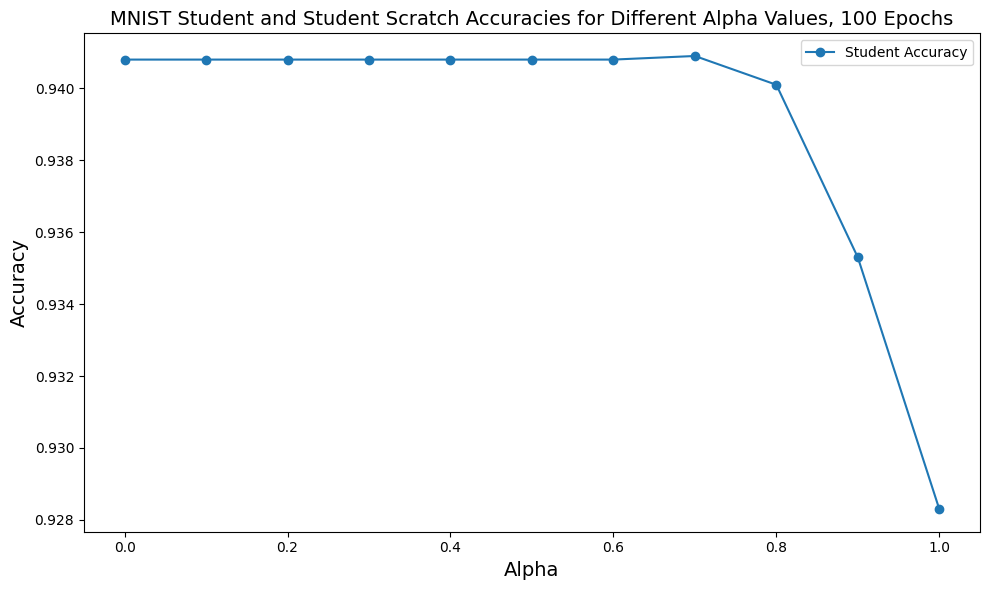

In [ ]:
# Plotting accuracies vs. alphas
plt.figure(figsize=(10, 6))


# Accuracy plot
# plt.subplot(1, 1, 2)
plt.plot(alpha_values, student_accuracies, label="Student Accuracy", marker='o')
# plt.plot(alpha_values, student_scratch_accuracies, label="Student Scratch Accuracy", marker='o')
plt.title('MNIST Student and Student Scratch Accuracies for Different Alpha Values, 100 Epochs', fontsize = 14)
plt.xlabel('Alpha', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.legend()


# Save the figure
plt.savefig('MNIST_100epochs_acc.png')

plt.tight_layout()
plt.show()

In [ ]:
student_accuracies

[0.9407999999821186,
 0.9407999999821186,
 0.9407999999821186,
 0.9407999999821186,
 0.9407999999821186,
 0.9407999999821186,
 0.9407999999821186,
 0.9409000016748905,
 0.9400999993085861,
 0.9353000000119209,
 0.9283000007271767]

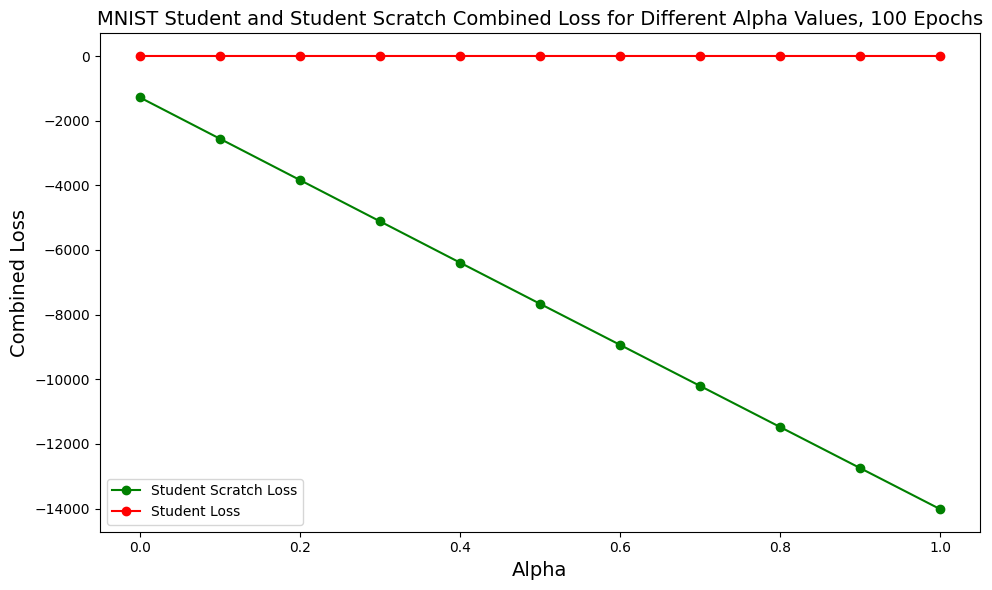

In [ ]:
# Accuracy plot for student trained from scratch
# plt.subplot(1, 2, 2)

plt.figure(figsize=(10, 6))
plt.plot(alpha_values, student_scratch_losses, label="Student Scratch Loss", marker='o', color='green')
plt.plot(alpha_values, student_losses, label="Student Loss", marker='o', color='red')

plt.title('MNIST Student and Student Scratch Combined Loss for Different Alpha Values, 100 Epochs', fontsize = 14)
plt.xlabel('Alpha', fontsize = 14)
plt.ylabel('Combined Loss', fontsize = 14)
plt.legend()

# Save the figure
plt.savefig('MNIST_100epochs_loss.png')

plt.tight_layout()
plt.show()

# Take first 10% of MNIST DATA

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms

from torch.utils.data import Subset

train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=transforms.Compose(
        [transforms.Resize(32), transforms.ToTensor()]
    ),
    download=True
)

# takes the first 10% images of MNIST train set
subset_train = Subset(train_data, indices=range(len(train_data) // 10))

100%|██████████| 9912422/9912422 [00:00<00:00, 82660748.29it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29785024.30it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26503659.43it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3685534.68it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



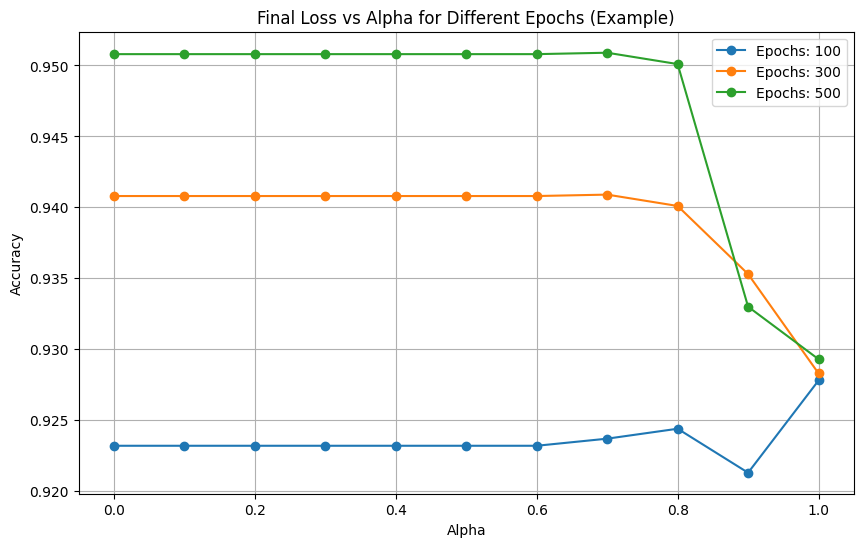

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
alpha_values = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# epoch_values = [100, 300, 500, 1000]
epoch_values = [100, 300, 500]

# Simulated losses for each alpha and epoch combination
loss_records = {
    100: [0.9231999963521957,
 0.9231999963521957,
 0.9231999963521957,
 0.9231999963521957,
 0.9231999963521957,
 0.9231999963521957,
 0.9231999963521957,
 0.9236999973654747,
 0.9244000017642975,
 0.9213000014424324,
 0.9277999997138977],  # Higher random losses for lower epochs
    300: [0.9407999999821186,
 0.9407999999821186,
 0.9407999999821186,
 0.9407999999821186,
 0.9407999999821186,
 0.9407999999821186,
 0.9407999999821186,
 0.9409000016748905,
 0.9400999993085861,
 0.9353000000119209,
 0.9283000007271767],
 500: [0.9507999999821186,
 0.9507999999821186,
 0.9507999999821186,
 0.9507999999821186,
 0.9507999999821186,
 0.9507999999821186,
 0.9507999999821186,
 0.9509000016748905,
 0.9500999993085861,
 0.933000000119209,
 0.9293000007271767]
}
# ,
#     500: np.random.rand(11) * 0.3 + 0.3,
#     1000: np.random.rand(11) * 0.2 + 0.2  # Lower random losses for higher epochs
# }

# Plotting
plt.figure(figsize=(10, 6))
for epochs, losses in loss_records.items():
    plt.plot(alpha_values, losses, marker='o', label=f'Epochs: {epochs}')

plt.title('Final Loss vs Alpha for Different Epochs (Example)')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()